In [1]:
%load_ext Cython

In [2]:
import cython
import numpy as np
import time
from cython.parallel import prange , parallel
from cython import nogil
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as mplt
import cartopy.crs as ccrs
from cartopy import config
import cartopy.feature

In [3]:
%%cython

# cython: boundscheck = False

import cython
import numpy as np
cimport numpy as np
from libc.stdlib cimport malloc, realloc, free, abort
from libc.math cimport cos , sin , sqrt , tan

@cython.wraparound(False)
@cython.boundscheck(False)
@cython.nonecheck(False)
@cython.cdivision(True)

cdef inline stokes_indices( double [:] N , double [:] M ):

    INDEX = np.zeros( len(N) ) 
    cdef double i , j 
    cdef int ii
    cdef int t1 = len(N)
    cdef int t2 = len(M)

    for ii in range( t1 ):
        i = N[ii]
        j = M[ii]
        if i == j:
            INDEX[ii] = ii
    
    return INDEX
  
def CS_IND(double [:] N , double [:] M):
    return stokes_indices(N , M)

print('index done!')

cdef inline double [:,:,:] COSSIN( double [:] lam , int n_max , int nt ):

    cdef int g = len(lam)
    cdef double [:,:,:] CS = np.zeros( ( n_max , g , 2 ) )
    cdef double [:] LAM = np.deg2rad(lam)
    cdef int i , m , num_threads
    cdef double p , l

    for i in range( g ):
        l = LAM[i]
        for m in range( n_max ):
            p = m*l
            CS[m,i,0] = cos(p)
            CS[m,i,1] = sin(p)
    return CS

def cos_and_sin( double [:] lam , int n_max , int nt ):
    return COSSIN( lam , n_max , nt )

print('COSSIN ok!')

cdef inline double [:,:,:,:] LEGENDRE( int n_max , double [:] phi , 
                                      double [:] F , double [:,:] G , 
                                      double [:,:] H , double [:,:] K ):
    cdef int i , n , m 
    cdef int gp = len(phi)
    cdef double [:,:,:,:] P = np.zeros( ( n_max , n_max , len(phi) , 3 ) )
    cdef double c , s , t

    cdef double [:] Phi = np.deg2rad(phi)
    
    P[0,0,:,0] = 1.

    for i in range( gp ):

        c = cos(Phi[i])
        s = sin(Phi[i])
        t = tan(Phi[i])

        P[1,0,i,0] = sqrt(3.)*s
        P[1,1,i,0] = sqrt(3.)*c

        m = 0
        n = 2

        while n < n_max:  

            P[n,m,i,0] = G[n,m]*P[n-1,m,i,0]*s - H[n,m]*P[n-2,m,i,0]
            P[n,m+1,i,0] = G[n,m]*P[n-1,m+1,i,0]*s - H[n,m]*P[n-2,m+1,i,0]
            P[n,m,i,1] = K[n,m]*P[n,m+1,i,0] - m*t*P[n,m,i,0]
            P[n,m,i,2] = P[n,m,i,0]*( ( m/(c*c) )*( m - (s*s) ) - n*(n+1) ) + t*K[n,m]*P[n,m+1,i,0]
                                       
            m = m + 1

            if m == n:

                P[n,n,i,0] = F[n]*c*P[n-1,n-1,i,0]
                P[n,n,i,1] = -n*t*P[n,n,i,0]
                P[n,n,i,2] = n*P[n,n,i,0]*( ( n - s**2 )/( c**2 ) - n - 1 )

                n = n + 1
                m = 0

    return P

def ALF( int n_max , double [:] phi , double [:] F , double [:,:] G , double [:,:] H , double [:,:] K ):
    return LEGENDRE( n_max , phi , F , G , H , K )

print('Legendre done!')

#################################################################################################################################
######################################## LUMPED COEFFICIENTS FUNCTIONS ##########################################################
#################################################################################################################################

cdef inline double [:,:,:] Lumped( double r , double [:] phi , int n_max , #given parameters and variables
                                   double [:] C , double [:] S , double [:] N ,  #Stokes coefficients and indexes
                                   double [:,:,:] P , double [:,:,:] dP , double [:,:,:] ddP , #ALF for every phi value
                                   double C20 , double a ): #setting C_{20} to 0 or to its actual value

    cdef int M 

    if C20 == 0: # Setting C20 value to 0 if we do not want it
        C[0] = 0.
        M = 2
    else:
        M = 0

    cdef int g = len(phi)
    cdef double Y = a/r
    cdef double rr = 1/r
    cdef double rrr = 1/(r*r)

    cdef int n , n_t , index , i , m

    cdef double [:,:,:] Lump = np.zeros( ( 12 , g , n_max ) )

    cdef double A , B , Ar , Br , Ap , Bp , Arr , Brr , Arp , Brp , App , Bpp

    for i in range( g ):
        for m in range( n_max ):

            A , B , Ar , Br , Ap , Bp , Arr , Brr , Arp , Brp , App , Bpp = 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0

            for n in range( M , n_max ):

                index = int( N[ n - 2 ] )

                A += P[ n , m , i ]*C[ index - n + m ]*(Y**n)
                B += P[ n , m , i ]*S[ index - n + m ]*(Y**n)

                Ar += P[ n , m , i ]*C[ index - n + m ]*(Y**n)*n
                Br += P[ n , m , i ]*S[ index - n + m ]*(Y**n)*n
                Ap += dP[ n , m , i ]*C[ index - n + m ]*(Y**n)
                Bp += dP[ n , m , i ]*S[ index - n + m ]*(Y**n)

                Arr += P[ n , m , i ]*C[ index - n + m ]*(Y**n)*n*(n+1)
                Brr += P[ n , m , i ]*S[ index - n + m ]*(Y**n)*n*(n+1)
                Arp += dP[ n , m , i ]*C[ index - n + m ]*(Y**n)*n
                Brp += dP[ n , m , i ]*S[ index - n + m ]*(Y**n)*n
                App += ddP[ n , m , i ]*C[ index - n + m ]*(Y**n)
                Bpp += ddP[ n , m , i ]*S[ index - n + m ]*(Y**n)

            Lump[ 0 , i , m  ] = A # Am
            Lump[ 1 , i , m  ] = B # Bm

            Lump[ 2 , i , m ] = (-rr)*Ar # dAm/dr
            Lump[ 3 , i , m ] = (-rr)*Br # dBm/dr
            Lump[ 4 , i , m ] = Ap # dAm/dp
            Lump[ 5 , i , m ] = Bp # dBm/dp

            Lump[ 6 , i , m ] = (-rrr)*Arr # d/dr(dAm/dr)
            Lump[ 7 , i , m ] = (-rrr)*Brr # d/dr(dBm/dr)
            Lump[ 8 , i , m ] = (-rr)*Arp # d/dp(dAm/dr)
            Lump[ 9 , i , m ] = (-rr)*Brp # d/dp(dBm/dr)
            Lump[ 10 , i , m ] = App # d/dp(dAm/dp)
            Lump[ 11 , i , m ] = Bpp # d/dp(dBm/dp)

    return Lump

def Lumped_py( double r , double [:] phi , int n_max , #given parameters and variables
               double [:] C , double [:] S , double [:] N ,  #Stokes coefficients and indexes
               double [:,:,:] P , double [:,:,:] dP , double [:,:,:] ddP , #ALF for every phi value
               double C20 , double a ): #setting C_{20} to 0 or to its actual value
    return Lumped( r , phi , n_max , C , S , N , P , dP , ddP , C20 , a )

print( 'Lumped Coefficients, done!' )

#################################################################################################################################
######################################## POTENTIAL FUNCTION #####################################################################
#################################################################################################################################

cdef inline double [:,:] Calculation( double r , double [:] lam , double [:] phi , # Variables for V(r,lambda,phi)
                                      int n_max , # Max degree
                                      double [:,:] COS , double [:,:] SIN , # cos(m*lambda) and sin(m*lambda)
                                      double [:,:] A , double [:,:] B , double GM ): # Lumped coefficients

    cdef int g1 = len(phi)
    cdef int g2 = len(lam)
    
    cdef double [:,:] Pot = np.zeros( ( g1 , g2 ) )

    cdef double J = GM/r #3986004.415e8/r # m^2/s^2

    cdef int i , j , m , n_t
    cdef double Cor
    
    for i in range(g1):
        for j in range(g2):
            Cor = 0.          
            for m in range( n_max ):
                Cor += A[ i , m ]*COS[ m , j ] + B[ i , m ]*SIN[ m , j ]
            Pot[ i , j ] = J*Cor
    return Pot

def Potential( double r , double [:] lam , double [:] phi , int n_max , double [:,:] COS , double [:,:] SIN , double [:,:] A , double [:,:] B , double GM ): 
    return Calculation( r , lam , phi , n_max , COS , SIN , A , B , GM )

print( 'Function OK!' )

#################################################################################################################################
######################################## NABLA POTENTIAL FUNCTION #####################################################################
#################################################################################################################################

cdef inline double [:,:,:] Nabla_Calculation( double r , double [:] lam , double [:] phi , # Variables for V(r,lambda,phi)
                                      int n_max , # Max degree
                                      double [:,:] COS , double [:,:] SIN , # cos(m*lambda) and sin(m*lambda)
                                      double [:,:] A , double [:,:] B , # Lumped coefs
                                      double [:,:] Ar , double [:,:] Br , # r-derivative of lumped coefs
                                      double [:,:] Ap , double [:,:] Bp , double GM ): # phi-derivative of lumped coefs

    cdef int g1 = len(phi)
    cdef int g2 = len(lam)
    
    cdef double [:,:,:] dPot = np.zeros( ( g1 , g2 , 3 ) )

    cdef double J = GM/r #3986004.415e8/r #m^2/s^2

    cdef int i , j , m , n_t , index
    cdef double Cor_r , Cor_p , Cor_l
    cdef double alpha , beta
    
    #openmp.omp_set_dynamic(1)
    #n_t = openmp.omp_get_num_threads()
    
    for i in range( g1 ):
        for j in range( g2 ):
            Cor_r = 0.   
            Cor_p = 0.
            Cor_l = 0.       
            for m in range( n_max ):
                alpha = COS[ m , j ]
                beta = SIN[ m , j ]
                Cor_r += alpha*( Ar[ i , m ] - ( A[ i , m ]/r ) ) + beta*( Br[ i , m ] - ( B[ i , m ]/r ) )
                Cor_p += alpha*Ap[ i , m ] + beta*Bp[ i , m ]
                Cor_l += m*( -A[ i , m ]*beta + B[ i , m ]*alpha )
            dPot[ i , j , 0 ] = J*Cor_r
            dPot[ i , j , 1 ] = J*Cor_p
            dPot[ i , j , 2 ] = J*Cor_l
    return dPot

def Nabla_Potential( double r , double [:] lam , double [:] phi , int n_max , double [:,:] COS , double [:,:] SIN , 
              double [:,:] A , double [:,:] B ,double [:,:] Ar , double [:,:] Br , double [:,:] Ap , double [:,:] Bp
                   , double GM): 
    return Nabla_Calculation( r , lam , phi , n_max , COS , SIN , A , B , Ar , Br , Ap , Bp , GM )

print( 'Potential gradient function, OK!' )

#################################################################################################################################
######################################## HESSIAN POTENTIAL FUNCTION #####################################################################
#################################################################################################################################

cdef inline double [:,:,:] Hessian_Calculation( double r , double [:] lam , double [:] phi , # Variables for V(r,lambda,phi)
                                      int n_max , # Max degree
                                      double [:,:] COS , double [:,:] SIN , # cos(m*lambda) and sin(m*lambda)
                                      double [:,:] A , double [:,:] B , # Lumped coefs
                                      double [:,:] Ar , double [:,:] Br , # r-derivative of lumped coefs
                                      double [:,:] Ap , double [:,:] Bp , # phi-derivative of lumped coefs
                                      double [:,:] Arr , double [:,:] Brr , # r,r-derivative of lumped coefs
                                      double [:,:] Arp , double [:,:] Brp , # r,phi-derivative of lumped coefs
                                      double [:,:] App , double [:,:] Bpp , double GM  ): # phi,phi-derivative of lumped coefs

    cdef int g1 = len(phi)
    cdef int g2 = len(lam)
    
    cdef double [:,:,:] ddPot = np.zeros( ( g1 , g2 , 6 ) )

    cdef double J = GM/r #3986004.415e8/r #m^2/s^2

    cdef int i , j , m , n_t , index
    cdef double Cor_rr , Cor_pp , Cor_ll , Cor_rp , Cor_rl , Cor_pl
    cdef double alpha , beta
    
    for i in range(g1):
        for j in range(g2):

            Cor_rr , Cor_pp , Cor_ll , Cor_rp , Cor_rl , Cor_pl = 0. , 0. , 0. , 0. , 0. , 0. 

            for m in range( n_max ):

                alpha = COS[ m , j ]
                beta = SIN[ m , j ]

                Cor_rr += alpha*( Arr[ i , m ] - 2.*Ar[ i , m ] + 2.*( A[ i , m ]/r ) ) + beta*( Brr[ i , m ] - 2.*Br[ i , m ] + 2.*( B[ i , m ]/r ) )
                Cor_pp += alpha*App[ i , m ] + beta*Bpp[ i , m ]
                Cor_ll += -m*m*( A[ i , m ]*alpha + B[ i , m ]*beta )
                Cor_rp += alpha*( Arp[ i , m ] - ( Ap[ i , m ]/r ) ) + beta*( Brp[ i , m ] - ( Bp[ i , m ]/r ) )
                Cor_rl += m*( -beta*( Ar[ i , m ] - ( A[ i , m ]/r ) ) + alpha*( Br[ i , m ] - ( B[ i , m ]/r ) ) )
                Cor_pl += m*( -beta*Ap[ i , m ] + alpha*Bp[ i , m ] )

            ddPot[ i , j , 0 ] = (J/r)*Cor_rr
            ddPot[ i , j , 1 ] = J*Cor_pp
            ddPot[ i , j , 2 ] = J*Cor_ll
            ddPot[ i , j , 3 ] = J*Cor_rp
            ddPot[ i , j , 4 ] = J*Cor_rl
            ddPot[ i , j , 5 ] = J*Cor_pl

    return ddPot

def Hessian_Potential( double r , double [:] lam , double [:] phi , # Variables for V(r,lambda,phi)
                                      int n_max , # Max degree
                                      double [:,:] COS , double [:,:] SIN , # cos(m*lambda) and sin(m*lambda)
                                      double [:,:] A , double [:,:] B , # Lumped coefs
                                      double [:,:] Ar , double [:,:] Br , # r-derivative of lumped coefs
                                      double [:,:] Ap , double [:,:] Bp , # phi-derivative of lumped coefs
                                      double [:,:] Arr , double [:,:] Brr , # r,r-derivative of lumped coefs
                                      double [:,:] Arp , double [:,:] Brp , # r,phi-derivative of lumped coefs
                                      double [:,:] App , double [:,:] Bpp , double GM ):
    return Hessian_Calculation( r , lam , phi , n_max , COS , SIN , A , B , Ar , Br , Ap , Bp , Arr , Brr , Arp , Brp , App , Bpp , GM )

print( 'Potential hessian function, OK!' )

#################################################################################################################################
######################################## GRAVITY DEVIATIONS #####################################################################
#################################################################################################################################

cdef inline double [:,:,:] Gravity_Anomaly__Disturbance( double r , double [:] phi , double [:] lam , 
                                         double [:,:] Pot , double [:,:] Pot_r ):

    cdef int i , j , num_threads

    cdef int g1 = len(phi)
    cdef int g2 = len(lam)

    cdef double [:,:,:] dg = np.zeros( ( g1 , g2 , 3 ) )
        
    for i in range( g1 ):
        for j in range( g2 ): 
            dg[ i , j , 0 ] = (-Pot_r[ i , j ] - ( 2./r )*Pot[ i , j ])*100 #Grav_ANOMALY
            dg[ i , j , 1 ] = -Pot_r[ i , j ]*100 #Grav_DISTURBANCE
            dg[ i , j , 2 ] = ( 2./r )*Pot[ i , j ]*100
    return dg

def grav_dev( double r , double [:] phi , double [:] lam , 
              double [:,:] Pot , double [:,:] Pot_r):
    return Gravity_Anomaly__Disturbance( r , phi , lam , Pot , Pot_r )

print( 'Gravities deviations Function ok!' )

cdef inline double F(int n):
    cdef double a
    if n == 0:
        a = 0
    elif n == 1:
        a = sqrt( (2.*n+1.)/n )
    else:
        a = sqrt( (2.*n+1.)/(2.*n) )
    return a

def f(int n):
    return F(n)

cdef inline double G(int n , int m):
    cdef double a
    if n == m:
        a = 0
    else:
        a = sqrt( (4.*n**2 - 1.)/(n**2 - m**2) )
    return a
    
def g(int n , int m):
    return G(n,m)

cdef inline double H(int n , int m):
    cdef double a
    if n == m:
        a = 0
    else:
        a = sqrt( ( (2.*n + 1.)*( (n - 1.)**2 - m**2) )/( (2.*n - 3.)*(n**2 - m**2) ) )
    return a
    
def h(int n , int m):
    return H(n,m)

cdef inline double K(int n , int m):
    cdef double a
    if m == 0:
        a = sqrt( (n - m)*(n + m + 1.)/2. )
    else:
        a = sqrt( (n - m)*(n + m + 1.) )
    return a
    
def k(int n , int m):
    return K(n,m)
    
print( 'Coefficients Functions, OK!' )

index done!
COSSIN ok!
Legendre done!
Lumped Coefficients, done!
Function OK!
Potential gradient function, OK!
Potential hessian function, OK!
Gravities deviations Function ok!
Coefficients Functions, OK!


Caricamento degli array.



In [4]:
t_in = time.perf_counter()

#A = np.genfromtxt( 'Stokes_Moon.txt' )
#A = np.genfromtxt('Stokes_Mars_95.txt')
#A = np.genfromtxt('Stokes_Venus.txt')

#A = np.genfromtxt( 'Stokes_96.txt' ) #EGM_96
#A = np.genfromtxt( 'Stokes_Coeffs.txt' ) #EGM_2008

# Moon : 
#GM , a , n_max , Earth , A = 4.90486959e12 , 1.7374e6 , 660 , False , np.genfromtxt( 'Stokes_Moon.txt' )

# Earth : 
GM , a , n_max , Earth , A = 3.986004415e14 , 6.378137e6 , 2000 , True , np.genfromtxt( 'Stokes_Coeffs.txt' )

# Mars : 
#GM , a , n_max , Earth , A = 4.2828372e13 , 3.3895e6 , 120 , False , np.genfromtxt('Stokes_Mars_95.txt')

# Venus :
#GM , a , n_max , Earth , A = 3.248599e14 , 6.0518e6 , 180 , False , np.genfromtxt('Stokes_Venus.txt')

r = a
res = 1

N = A[:,0] 
M = A[:,1] 
C = A[:,2] 
S = A[:,3] 

STOKES_INDEX = CS_IND( N , M )
ST_IN = STOKES_INDEX[STOKES_INDEX != 0]
SI = ST_IN.astype(np.int)

print( 'Stokes coefficients, check!' )
print( "Number of coefficients: " , n_max )

phi = np.linspace( 90. , -90. , 180*res )
lam = np.linspace( -180. , 180. , 360*res )

F = np.zeros( n_max )
G = np.zeros( ( n_max , n_max ) )
H = np.zeros( ( n_max , n_max ) )
K = np.zeros( ( n_max , n_max ) )

# f , g , h , k coefficients
for n in range(n_max):
    F[n] = f(n)
    for m in range(n+1):
        G[n , m] = g(n , m)
        H[n , m] = h(n , m)
        K[n , m] = k(n , m)

C20 = 0 # parameter to choose between the full potential and the disturbing potential

save = False

t_fin = time.perf_counter()

print( "Time for computation = " , " {:10.4f}".format( t_fin - t_in ) , ' s' )

print('everything done!')

Stokes coefficients, check!
Number of coefficients:  2000
Time for computation =      17.0507  s
everything done!


In [5]:
t_in = time.perf_counter()
cands = cos_and_sin( lam , n_max , nt = 8 )
t_fin = time.perf_counter()

COS = cands[:,:,0]
SIN = cands[:,:,1]

print( "Time for computation COSSIN = " , " {:10.4f}".format( t_fin - t_in ) , ' s' )

t_in = time.perf_counter()
Legendre_func = ALF( n_max , phi , F , G , H , K )
t_fin = time.perf_counter()

P = Legendre_func[:,:,:,0]
dP = Legendre_func[:,:,:,1]
ddP = Legendre_func[:,:,:,2]

print( "Time for computation nALF = " , " {:10.4f}".format( t_fin - t_in ) , ' s' )

t_in = time.perf_counter()

L_Coeffs = Lumped_py( r , phi , n_max , C , S , ST_IN , P , dP , ddP , 0 , a )

A , B = L_Coeffs[0,:,:] , L_Coeffs[1,:,:]

Ar , Br = L_Coeffs[2,:,:] , L_Coeffs[3,:,:]
Ap , Bp = L_Coeffs[4,:,:] , L_Coeffs[5,:,:]

Arr , Brr = L_Coeffs[6,:,:] , L_Coeffs[7,:,:]
Arp , Brp = L_Coeffs[8,:,:] , L_Coeffs[9,:,:]
App , Bpp = L_Coeffs[10,:,:] , L_Coeffs[11,:,:]

t_fin = time.perf_counter()

print( "Time for computation LUMPCOEFFS = " , " {:10.4f}".format( t_fin - t_in ) , ' s' )

t_in = time.perf_counter()
Pot  = Potential( r , lam , phi , n_max , COS , SIN , A , B , GM )
t_fin = time.perf_counter()


print( "Time for computation  V = " , " {:10.4f}".format( t_fin - t_in ) , ' s' )

t_in = time.perf_counter()
nabla_Pot  = Nabla_Potential( r , lam , phi , n_max , COS , SIN , A , B , Ar , Br , Ap , Bp , GM )
t_fin = time.perf_counter()

print( "Time for computation nablaV = " , " {:10.4f}".format( t_fin - t_in ) , ' s' )

t_in = time.perf_counter()
hessian_Pot  = Hessian_Potential( r , lam , phi , n_max , COS , SIN , A , B , Ar , Br , Ap , Bp , Arr , Brr , Arp , Brp , App , Bpp , GM )
t_fin = time.perf_counter()

print( "Time for computation HessianV = " , " {:10.4f}".format( t_fin - t_in ) , ' s' )

t_in = time.perf_counter()
deltas_g = grav_dev( r , phi , lam , Pot , nabla_Pot[:,:,0] )
t_fin = time.perf_counter()

print( "Time for computation gravity = " , " {:10.4f}".format( t_fin - t_in ) , ' s' )

Time for computation COSSIN =       0.0222  s
Time for computation nALF =      20.6744  s
Time for computation LUMPCOEFFS =    7543.3940  s
Time for computation  V =       0.7719  s
Time for computation nablaV =       1.3490  s
Time for computation HessianV =       2.6807  s
Time for computation gravity =       0.0009  s


**-------------------------------------------------------------------------------------------------------------------------------------------------------------------**

Color Plot del Potenziale

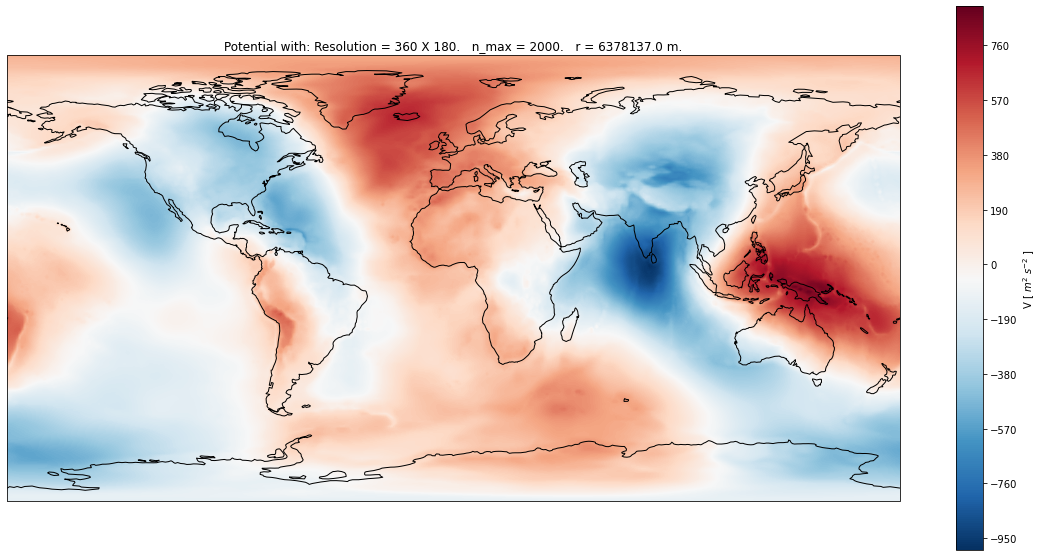

Time for computation =       9.4182  s


In [6]:
t_in = time.perf_counter()
plt.figure( figsize = [ 20 , 10 ] )

ax = plt.axes( projection=ccrs.PlateCarree() )

cs = plt.contourf( lam , phi , Pot , 900  , transform=ccrs.PlateCarree() , cmap = cm.RdBu_r )

if Earth == True:
    ax.coastlines()
    
cbar = plt.colorbar( cs , orientation='vertical' )#, format=mplt.FuncFormatter(fmt) )
cbar.set_label( 'V [ $m^2$ $s^{-2}$ ]' , rotation=90 )
cbar.solids.set_edgecolor( "face" )

plt.xlabel( '$\lambda$ [deg]' )
plt.ylabel( '$\phi$ [deg]' )

plt.title( 'Potential with: Resolution = ' + str(len(lam)) + ' X ' + str(len(phi)) + '.   n_max = ' + str(n_max) + '.   r = ' + str(r) + ' m.')

if save == True:

    #plt.savefig( 'V_' + str(len(lam)) + ' X ' + str(len(phi)) + ' n_max' + str(n_max) + '.pdf' ) 
    plt.savefig( 'V_' + str(len(lam)) + ' X ' + str(len(phi)) + ' n_max' + str(n_max) + '.png' ) 
    
plt.show()
t_fin = time.perf_counter()

print( "Time for computation = " , " {:10.4f}".format( t_fin - t_in ) , ' s' )

Color plots del gradiente.

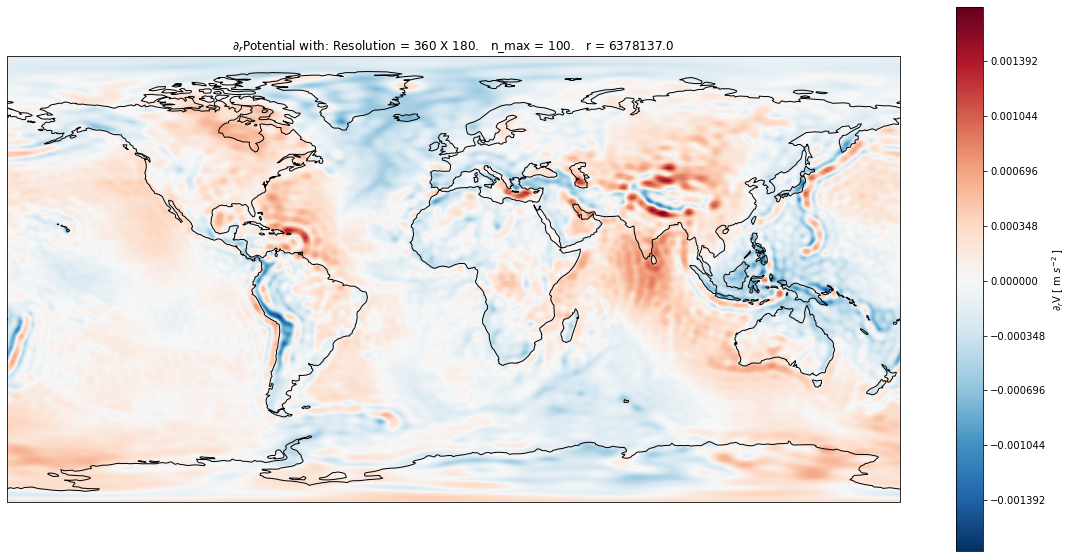

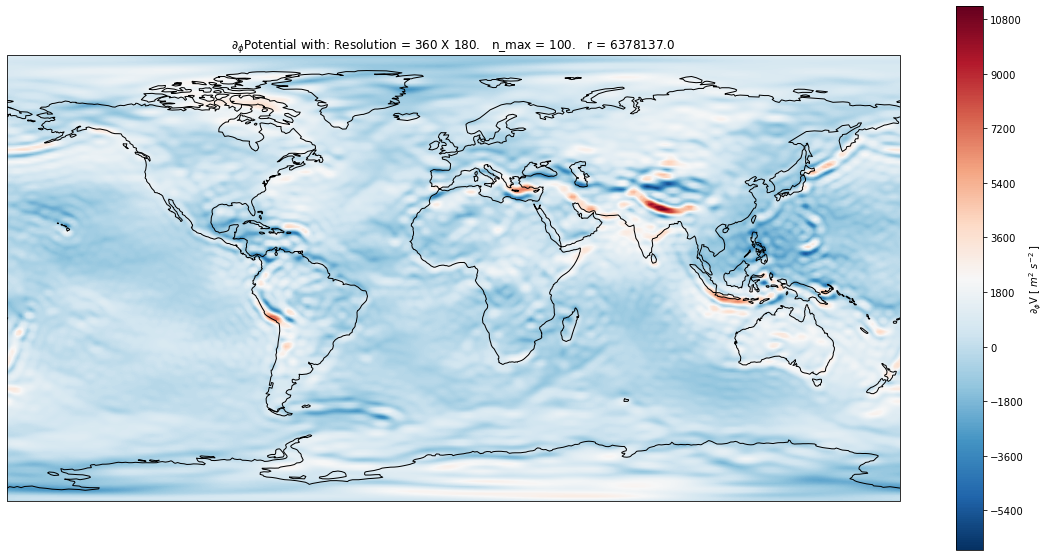

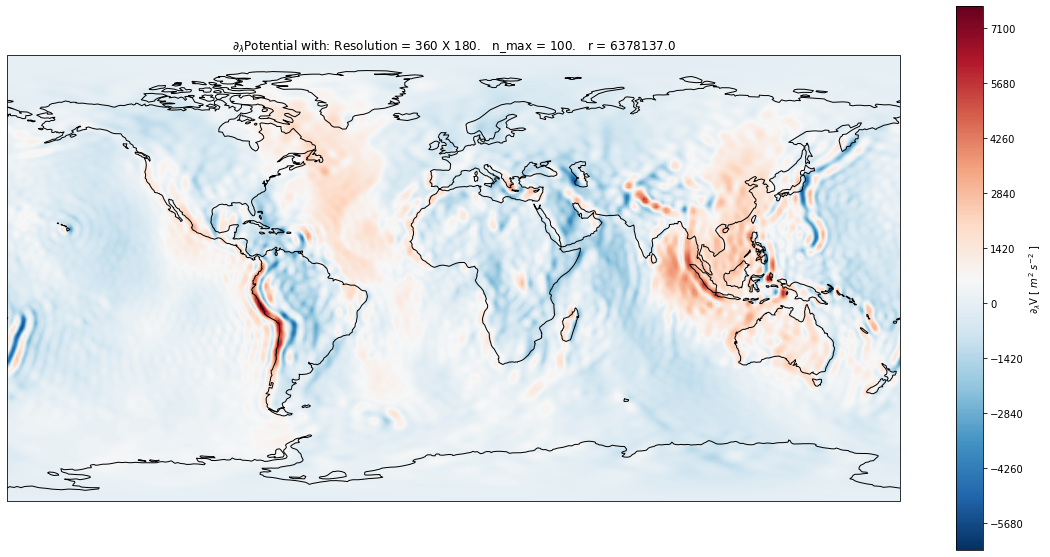

In [31]:
plt.figure( figsize = [ 20 , 10 ] )

ax = plt.axes( projection=ccrs.PlateCarree() )

cs = plt.contourf( lam , phi , nabla_Pot[:,:,0] , 900  , transform=ccrs.PlateCarree() , cmap = cm.RdBu_r )

if Earth == True:
    ax.coastlines()
    
cbar = plt.colorbar( cs , orientation='vertical' )#, format=mplt.FuncFormatter(fmt) )
cbar.set_label( '$\partial_{r}$V [ m $s^{-2}$ ]' , rotation=90 )
cbar.solids.set_edgecolor( "face" )

plt.xlabel( '$\lambda$ [deg]' )
plt.ylabel( '$\phi$ [deg]' )

plt.title( '$\partial_{r}$Potential with: Resolution = ' + str(len(lam)) + ' X ' + str(len(phi)) + '.   n_max = ' + str(n_max) + '.   r = ' + str(r) )

if save == True:
    #plt.savefig( 'drV_' + str(len(lam)) + ' X ' + str(len(phi)) + ' n_max' + str(n_max) + '.pdf' ) 
    plt.savefig( 'drV_' + str(len(lam)) + ' X ' + str(len(phi)) + ' n_max' + str(n_max) + '.png' ) 

plt.show()

###########################################################################################################

plt.figure( figsize = [ 20 , 10 ] )

ax = plt.axes( projection=ccrs.PlateCarree() )

cs = plt.contourf( lam , phi , nabla_Pot[:,:,1] , 900  , transform=ccrs.PlateCarree() , cmap = cm.RdBu_r )

if Earth == True:
    ax.coastlines()
    
cbar = plt.colorbar( cs , orientation='vertical' )#, format=mplt.FuncFormatter(fmt) )
cbar.set_label( '$\partial_{\phi}$V [ $m^2$ $s^{-2}$ ]' , rotation=90 )
cbar.solids.set_edgecolor( "face" )

plt.xlabel( '$\lambda$ [deg]' )
plt.ylabel( '$\phi$ [deg]' )

plt.title( '$\partial_{\phi}$Potential with: Resolution = ' + str(len(lam)) + ' X ' + str(len(phi)) + '.   n_max = ' + str(n_max) + '.   r = ' + str(r) )

if save == True:

    #plt.savefig( 'dpV_' + str(len(lam)) + ' X ' + str(len(phi)) + ' n_max' + str(n_max) + '.pdf' ) 
    plt.savefig( 'dpV_' + str(len(lam)) + ' X ' + str(len(phi)) + ' n_max' + str(n_max) + '.png' ) 

plt.show()

###########################################################################################################

plt.figure( figsize = [ 20 , 10 ] )

ax = plt.axes( projection=ccrs.PlateCarree() )

cs = plt.contourf( lam , phi , nabla_Pot[:,:,2] , 900  , transform=ccrs.PlateCarree() , cmap = cm.RdBu_r )

if Earth == True:
    ax.coastlines()
    
cbar = plt.colorbar( cs , orientation='vertical' )#, format=mplt.FuncFormatter(fmt) )
cbar.set_label( '$\partial_{\lambda}$V [ $m^2$ $s^{-2}$ ]' , rotation=90 )
cbar.solids.set_edgecolor( "face" )

plt.xlabel( '$\lambda$ [deg]' )
plt.ylabel( '$\phi$ [deg]' )

plt.title( '$\partial_{\lambda}$Potential with: Resolution = ' + str(len(lam)) + ' X ' + str(len(phi)) + '.   n_max = ' + str(n_max) + '.   r = ' + str(r) )

if save == True:

    #plt.savefig( 'dlV_' + str(len(lam)) + ' X ' + str(len(phi)) + ' n_max' + str(n_max) + '.pdf' ) 
    plt.savefig( 'dlV_' + str(len(lam)) + ' X ' + str(len(phi)) + ' n_max' + str(n_max) + '.png' ) 

plt.show()

Color plots dell'Hessiana.

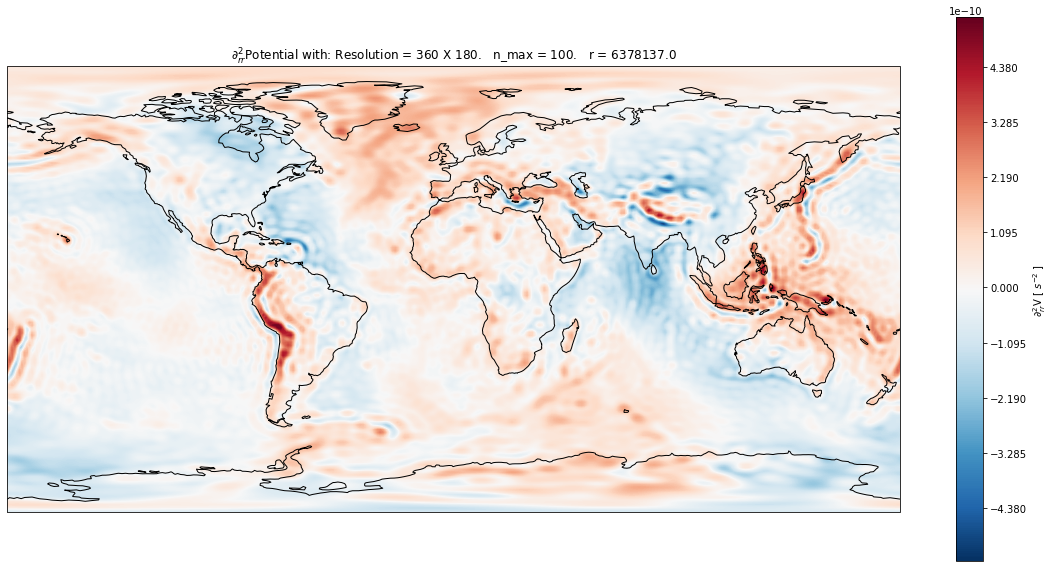

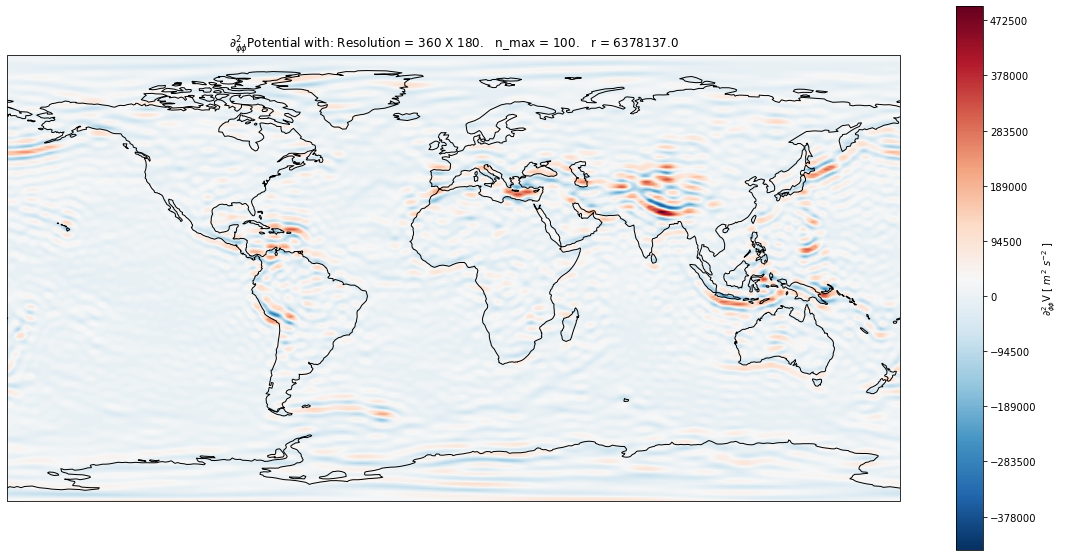

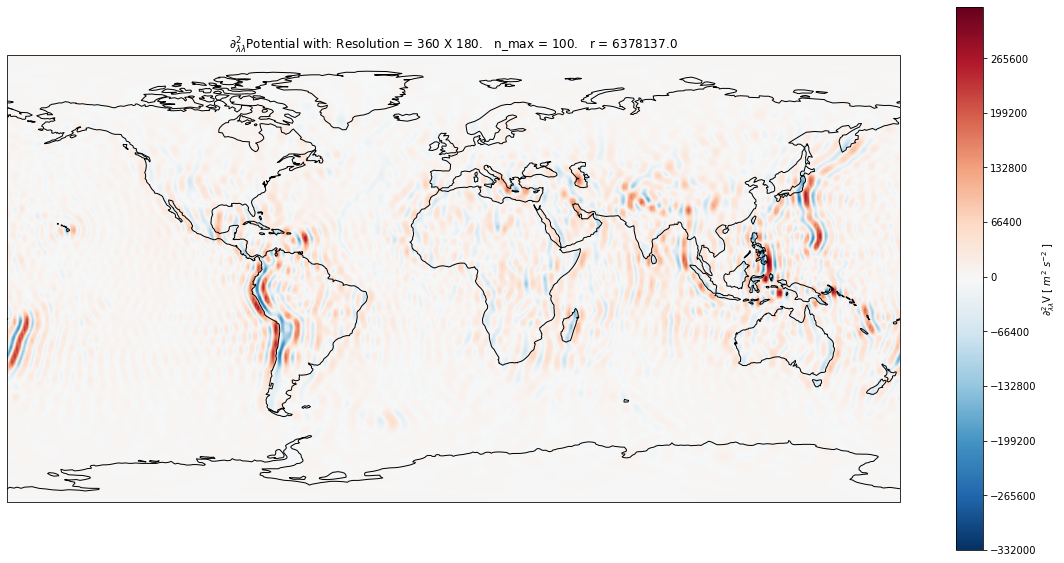

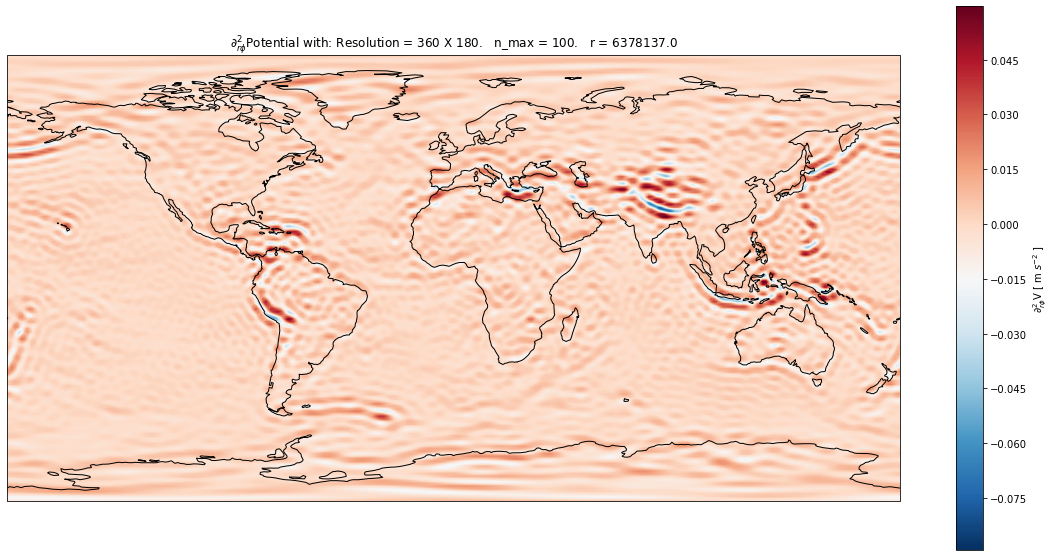

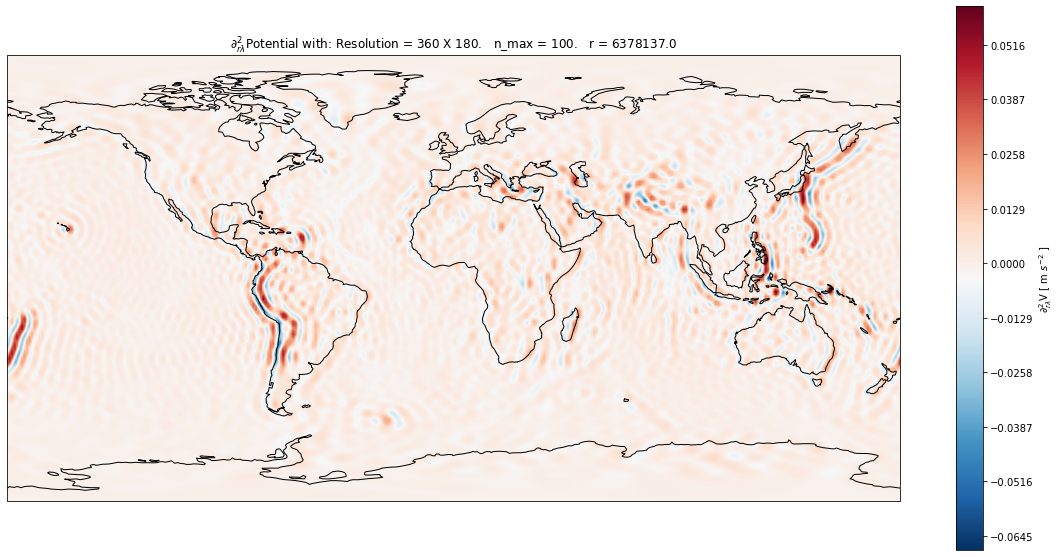

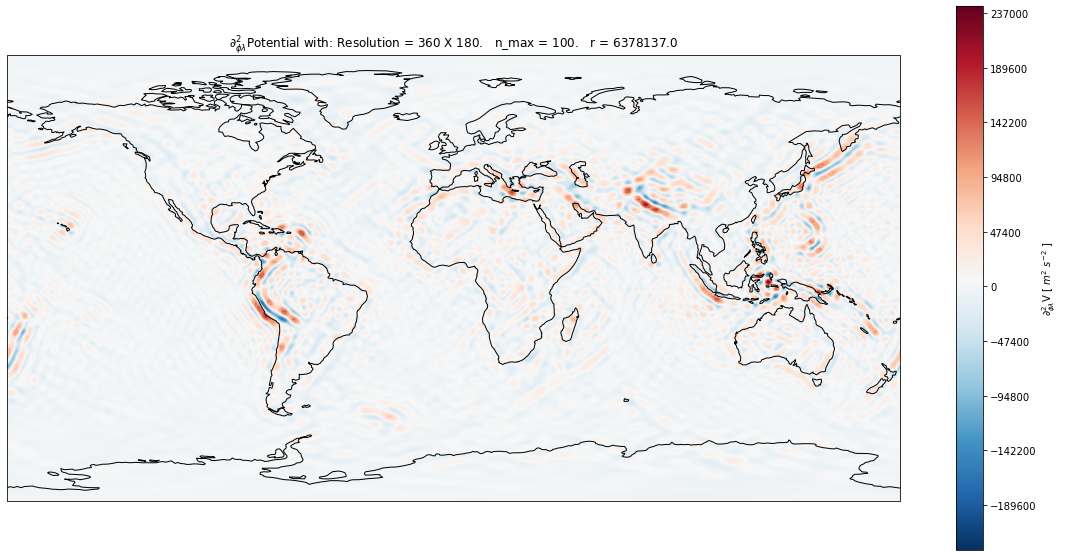

In [32]:
plt.figure( figsize = [ 20 , 10 ] )

ax = plt.axes( projection=ccrs.PlateCarree() )

cs = plt.contourf( lam , phi , hessian_Pot[:,:,0] , 900  , transform=ccrs.PlateCarree() , cmap = cm.RdBu_r )

if Earth == True:
    ax.coastlines()
    
cbar = plt.colorbar( cs , orientation='vertical' )#, format=mplt.FuncFormatter(fmt) )
cbar.set_label( '$\partial_{rr}^{2}$V [ $s^{-2}$ ]' , rotation=90 )
cbar.solids.set_edgecolor( "face" )

plt.xlabel( '$\lambda$ [deg]' )
plt.ylabel( '$\phi$ [deg]' )

plt.title( '$\partial_{rr}^{2}$Potential with: Resolution = ' + str(len(lam)) + ' X ' + str(len(phi)) + '.   n_max = ' + str(n_max) + '.   r = ' + str(r) )

if save == True:

    plt.savefig( 'drrV_' + str(len(lam)) + ' X ' + str(len(phi)) + ' n_max' + str(n_max) + '.pdf' ) 
    plt.savefig( 'drrV_' + str(len(lam)) + ' X ' + str(len(phi)) + ' n_max' + str(n_max) + '.png' ) 

plt.show()

###########################################################################################################

plt.figure( figsize = [ 20 , 10 ] )

ax = plt.axes( projection=ccrs.PlateCarree() )

cs = plt.contourf( lam , phi , hessian_Pot[:,:,1] , 900  , transform=ccrs.PlateCarree() , cmap = cm.RdBu_r )

if Earth == True:
    ax.coastlines()
    
cbar = plt.colorbar( cs , orientation='vertical' )#, format=mplt.FuncFormatter(fmt) )
cbar.set_label( '$\partial_{\phi \phi}^{2}$V [ $m^2$ $s^{-2}$ ]' , rotation=90 )
cbar.solids.set_edgecolor( "face" )

plt.xlabel( '$\lambda$ [deg]' )
plt.ylabel( '$\phi$ [deg]' )

plt.title( '$\partial_{\phi \phi}^{2}$Potential with: Resolution = ' + str(len(lam)) + ' X ' + str(len(phi)) + '.   n_max = ' + str(n_max) + '.   r = ' + str(r) )

if save == True:

    plt.savefig( 'dppV_' + str(len(lam)) + ' X ' + str(len(phi)) + ' n_max' + str(n_max) + '.pdf' ) 
    plt.savefig( 'dppV_' + str(len(lam)) + ' X ' + str(len(phi)) + ' n_max' + str(n_max) + '.png' ) 

plt.show()

###########################################################################################################

plt.figure( figsize = [ 20 , 10 ] )

ax = plt.axes( projection=ccrs.PlateCarree() )

cs = plt.contourf( lam , phi , hessian_Pot[:,:,2] , 900  , transform=ccrs.PlateCarree() , cmap = cm.RdBu_r )

if Earth == True:
    ax.coastlines()
    
cbar = plt.colorbar( cs , orientation='vertical' )#, format=mplt.FuncFormatter(fmt) )
cbar.set_label( '$\partial_{\lambda \lambda}^{2}$V [ $m^2$ $s^{-2}$ ]' , rotation=90 )
cbar.solids.set_edgecolor( "face" )

plt.xlabel( '$\lambda$ [deg]' )
plt.ylabel( '$\phi$ [deg]' )

plt.title( '$\partial_{\lambda \lambda}^{2}$Potential with: Resolution = ' + str(len(lam)) + ' X ' + str(len(phi)) + '.   n_max = ' + str(n_max) + '.   r = ' + str(r) )

if save == True:

    plt.savefig( 'dllV_' + str(len(lam)) + ' X ' + str(len(phi)) + ' n_max' + str(n_max) + '.pdf' ) 
    plt.savefig( 'dllV_' + str(len(lam)) + ' X ' + str(len(phi)) + ' n_max' + str(n_max) + '.png' ) 

plt.show()

###########################################################################################################

plt.figure( figsize = [ 20 , 10 ] )

ax = plt.axes( projection=ccrs.PlateCarree() )

cs = plt.contourf( lam , phi , hessian_Pot[:,:,3] , 900  , transform=ccrs.PlateCarree() , cmap = cm.RdBu_r )

if Earth == True:
    ax.coastlines()
    
cbar = plt.colorbar( cs , orientation='vertical' )#, format=mplt.FuncFormatter(fmt) )
cbar.set_label( '$\partial_{r \phi}^{2}$V [ m $s^{-2}$ ]' , rotation=90 )
cbar.solids.set_edgecolor( "face" )

plt.xlabel( '$\lambda$ [deg]' )
plt.ylabel( '$\phi$ [deg]' )

plt.title( '$\partial_{r \phi}^{2}$Potential with: Resolution = ' + str(len(lam)) + ' X ' + str(len(phi)) + '.   n_max = ' + str(n_max) + '.   r = ' + str(r) )

if save == True:

    plt.savefig( 'drpV_' + str(len(lam)) + ' X ' + str(len(phi)) + ' n_max' + str(n_max) + '.pdf' ) 
    plt.savefig( 'drpV_' + str(len(lam)) + ' X ' + str(len(phi)) + ' n_max' + str(n_max) + '.png' ) 

plt.show()

###########################################################################################################

plt.figure( figsize = [ 20 , 10 ] )

ax = plt.axes( projection=ccrs.PlateCarree() )

cs = plt.contourf( lam , phi , hessian_Pot[:,:,4] , 900  , transform=ccrs.PlateCarree() , cmap = cm.RdBu_r )

if Earth == True:
    ax.coastlines()
    
cbar = plt.colorbar( cs , orientation='vertical' )#, format=mplt.FuncFormatter(fmt) )
cbar.set_label( '$\partial_{r \lambda}^{2}$V [ m $s^{-2}$ ]' , rotation=90 )
cbar.solids.set_edgecolor( "face" )

plt.xlabel( '$\lambda$ [deg]' )
plt.ylabel( '$\phi$ [deg]' )

plt.title( '$\partial_{r \lambda}^{2}$Potential with: Resolution = ' + str(len(lam)) + ' X ' + str(len(phi)) + '.   n_max = ' + str(n_max) + '.   r = ' + str(r) )

if save == True:

    plt.savefig( 'drlV_' + str(len(lam)) + ' X ' + str(len(phi)) + ' n_max' + str(n_max) + '.pdf' ) 
    plt.savefig( 'drlV_' + str(len(lam)) + ' X ' + str(len(phi)) + ' n_max' + str(n_max) + '.png' ) 

plt.show()

###########################################################################################################

plt.figure( figsize = [ 20 , 10 ] )

ax = plt.axes( projection=ccrs.PlateCarree() )

cs = plt.contourf( lam , phi , hessian_Pot[:,:,5] , 900  , transform=ccrs.PlateCarree() , cmap = cm.RdBu_r )

if Earth == True:
    ax.coastlines()
    
cbar = plt.colorbar( cs , orientation='vertical' )#, format=mplt.FuncFormatter(fmt) )
cbar.set_label( '$\partial_{\phi \lambda}^{2}$V [ $m^2$ $s^{-2}$ ]' , rotation=90 )
cbar.solids.set_edgecolor( "face" )

plt.xlabel( '$\lambda$ [deg]' )
plt.ylabel( '$\phi$ [deg]' )

plt.title( '$\partial_{\phi \lambda}^{2}$Potential with: Resolution = ' + str(len(lam)) + ' X ' + str(len(phi)) + '.   n_max = ' + str(n_max) + '.   r = ' + str(r) )

if save == True:

    plt.savefig( 'dplV_' + str(len(lam)) + ' X ' + str(len(phi)) + ' n_max' + str(n_max) + '.pdf' ) 
    plt.savefig( 'dplV_' + str(len(lam)) + ' X ' + str(len(phi)) + ' n_max' + str(n_max) + '.png' ) 

plt.show()

Color plot di anomalia e disturbo gravitazionale

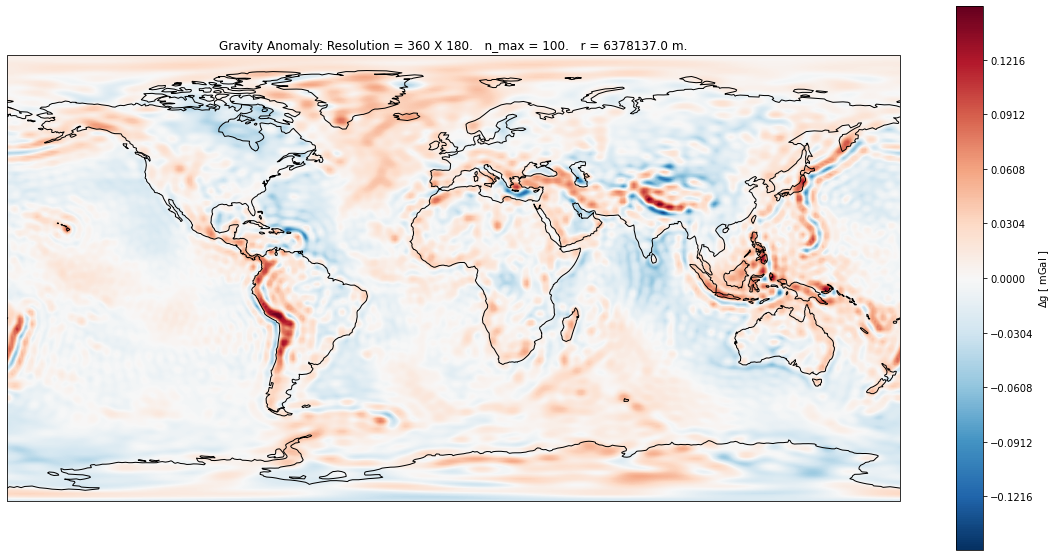

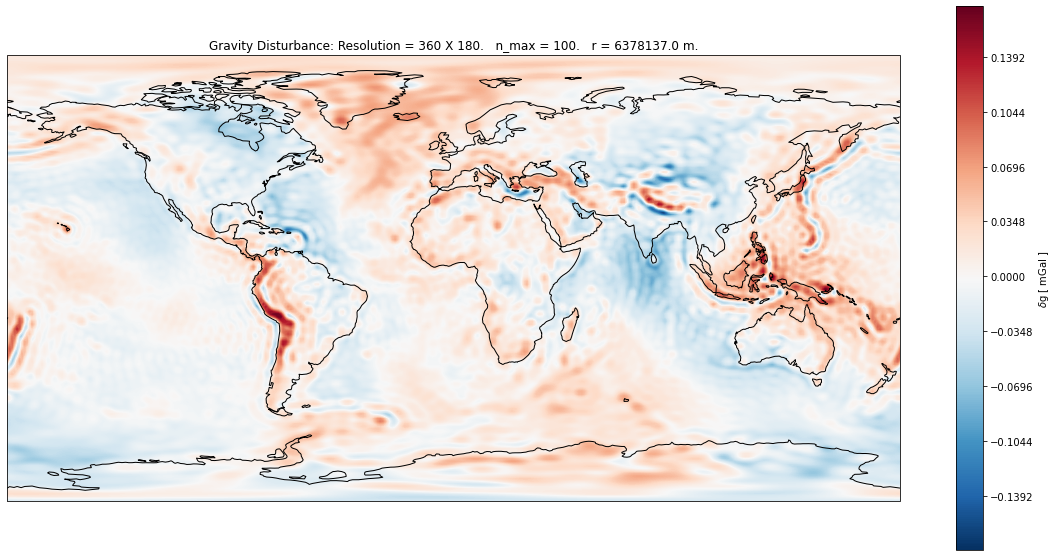

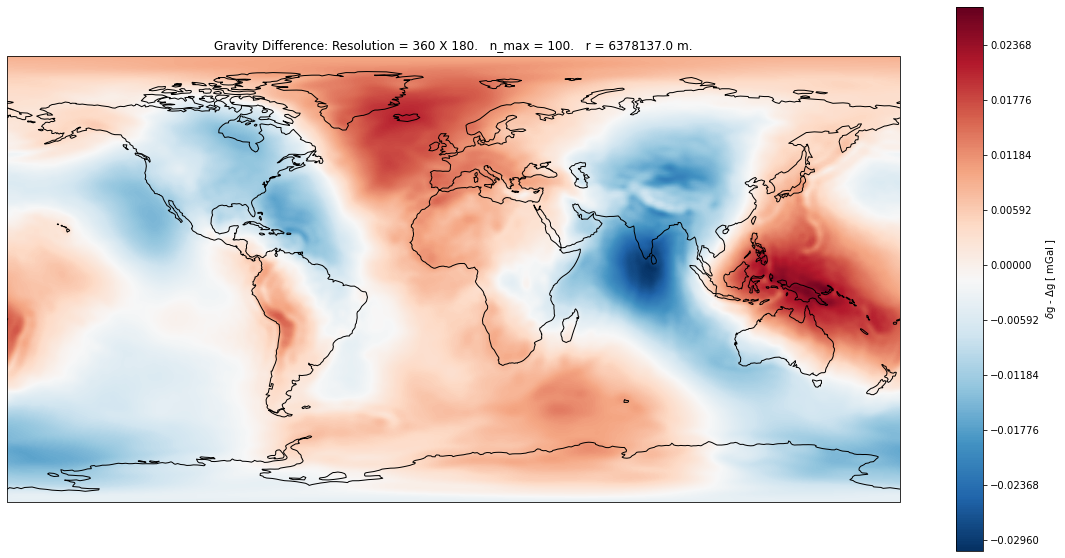

In [33]:
plt.figure( figsize = [ 20 , 10 ] )

ax = plt.axes( projection=ccrs.PlateCarree() )

Dg = deltas_g[:,:,0]

cs = plt.contourf( lam , phi , Dg , 900  , transform=ccrs.PlateCarree() , cmap = cm.RdBu_r )

if Earth == True:
    ax.coastlines()
    
cbar = plt.colorbar( cs , orientation='vertical' )#, format=mplt.FuncFormatter(fmt) )
cbar.set_label( '$\Delta$g [ mGal ]' , rotation=90 )
cbar.solids.set_edgecolor( "face" )

plt.xlabel( '$\lambda$ [deg]' )
plt.ylabel( '$\phi$ [deg]' )

plt.title( 'Gravity Anomaly: Resolution = ' + str(len(lam)) + ' X ' + str(len(phi)) + '.   n_max = ' + str(n_max) + '.   r = ' + str(r) + ' m.')

if save == True:

    plt.savefig( 'DELTAg_' + str(len(lam)) + ' X ' + str(len(phi)) + ' n_max' + str(n_max) + '.pdf' ) 
    plt.savefig( 'DELTAg_' + str(len(lam)) + ' X ' + str(len(phi)) + ' n_max' + str(n_max) + '.png' ) 

plt.show()

#---------------------------------------------------------------------------------------------------------------------------------------------------------

plt.figure( figsize = [ 20 , 10 ] )

ax = plt.axes( projection=ccrs.PlateCarree() )

cs = plt.contourf( lam , phi , deltas_g[:,:,1] , 900  , transform=ccrs.PlateCarree() , cmap = cm.RdBu_r )

if Earth == True:
    ax.coastlines()
    
cbar = plt.colorbar( cs , orientation='vertical' )#, format=mplt.FuncFormatter(fmt) )
cbar.set_label( '$\delta$g [ mGal ]' , rotation=90 )
cbar.solids.set_edgecolor( "face" )

plt.xlabel( '$\lambda$ [deg]' )
plt.ylabel( '$\phi$ [deg]' )

plt.title( 'Gravity Disturbance: Resolution = ' + str(len(lam)) + ' X ' + str(len(phi)) + '.   n_max = ' + str(n_max) + '.   r = ' + str(r) + ' m.')

if save == True:

    plt.savefig( 'deltag_' + str(len(lam)) + ' X ' + str(len(phi)) + ' n_max' + str(n_max) + '.pdf' ) 
    plt.savefig( 'deltag_' + str(len(lam)) + ' X ' + str(len(phi)) + ' n_max' + str(n_max) + '.png' ) 

plt.show()

#---------------------------------------------------------------------------------------------------------------------------------------------------------

plt.figure( figsize = [ 20 , 10 ] )

ax = plt.axes( projection=ccrs.PlateCarree() )

cs = plt.contourf( lam , phi , deltas_g[:,:,2] , 900  , transform=ccrs.PlateCarree() , cmap = cm.RdBu_r )

if Earth == True:
    ax.coastlines()
    
cbar = plt.colorbar( cs , orientation='vertical' )#, format=mplt.FuncFormatter(fmt) )
cbar.set_label( '$\delta$g - $\Delta$g [ mGal ]' , rotation=90 )
cbar.solids.set_edgecolor( "face" )

plt.xlabel( '$\lambda$ [deg]' )
plt.ylabel( '$\phi$ [deg]' )

plt.title( 'Gravity Difference: Resolution = ' + str(len(lam)) + ' X ' + str(len(phi)) + '.   n_max = ' + str(n_max) + '.   r = ' + str(r) + ' m.')

if save == True:

    plt.savefig( 'deltag_' + str(len(lam)) + ' X ' + str(len(phi)) + ' n_max' + str(n_max) + '.pdf' ) 
    plt.savefig( 'deltag_' + str(len(lam)) + ' X ' + str(len(phi)) + ' n_max' + str(n_max) + '.png' ) 

plt.show()